In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
# Celda 1: Carga y Preparación de Datos (Modificada v2)

# 1.1) Librerías y Autenticación
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# No necesitas importar Pipeline, ColumnTransformer, OneHotEncoder, lgb aquí si solo es preparación de datos
# import lightgbm as lgb # Lo usarás en celdas posteriores
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import os
from google.colab import auth
from pandas_gbq import read_gbq
# from sklearn.compose import ColumnTransformer # Lo usarás después
# from sklearn.preprocessing import StandardScaler, OneHotEncoder # Lo usarás después

print("Autenticando usuario para acceso a GCP...")
auth.authenticate_user()
print("✅ Usuario autenticado.")

# 1.2) Configuración BigQuery
PROJECT_ID    = "pokemon-cards-project"   # tu Project ID
BQ_DATASET    = "pokemon_dataset"
BQ_TABLE_META = "card_metadata"

# 1.3) Carga de datos desde BigQuery
print("\nCargando datos desde BigQuery...")

# Precios (todas las monthly_YYYY_MM_DD)
sql_prices = f"""
SELECT
  PARSE_DATE('%Y_%m_%d', _TABLE_SUFFIX) AS fecha,
  id                                    AS card_id,
  cm_averageSellPrice                   AS precio,
  cm_trendPrice                         AS cm_trendPrice,
  cm_avg1                               AS cm_avg1,
  cm_avg7                               AS cm_avg7,
  cm_avg30                              AS cm_avg30
FROM `{PROJECT_ID}.{BQ_DATASET}.monthly_*`
WHERE _TABLE_SUFFIX BETWEEN '2020_01_01'
  AND FORMAT_DATE('%Y_%m_%d', CURRENT_DATE())
ORDER BY card_id, fecha
"""
try:
    df_prices = read_gbq(sql_prices, project_id=PROJECT_ID)
    print(f"df_prices cargado. Shape: {df_prices.shape}")
    print(f"Columnas en df_prices: {df_prices.columns.tolist()}")
except Exception as e:
    print(f"ERROR cargando df_prices: {e}")
    print("Verifica que TODAS las columnas seleccionadas (cm_trendPrice, cm_avg1, cm_avg7, cm_avg30) existan en tus tablas 'monthly_*' de BigQuery.")
    df_prices = pd.DataFrame()

# Metadatos
sql_meta = f"""
SELECT
  id           AS card_id,
  artist       AS artist_name,
  name         AS pokemon_name, -- Nombre original de la carta
  rarity       AS rarity,       -- Añadido alias para consistencia, aunque no estrictamente necesario si el nombre es igual
  set_name     AS set_name,     -- Añadido alias
  types,
  supertype,
  subtypes
FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE_META}`
"""
try:
    df_meta = read_gbq(sql_meta, project_id=PROJECT_ID)
    print(f"df_meta cargado. Shape: {df_meta.shape}")
    print(f"Columnas en df_meta: {df_meta.columns.tolist()}")
except Exception as e:
    print(f"ERROR cargando df_meta: {e}")
    df_meta = pd.DataFrame()

if not df_prices.empty and not df_meta.empty:
    # --- 1.4) Preparación de Datos para el Modelo ---
    print("\n--- Iniciando preparación de datos para el modelo ---")

    df_prices['fecha'] = pd.to_datetime(df_prices['fecha'])
    df_prices.sort_values(['card_id', 'fecha'], inplace=True)

    # Crear features de lag y diferencia de días
    df_prices['prev_price'] = df_prices.groupby('card_id')['precio'].shift(1)
    df_prices['prev_fecha'] = df_prices.groupby('card_id')['fecha'].shift(1)
    df_prices['days_since_prev_snapshot'] = (df_prices['fecha'] - df_prices['prev_fecha']).dt.days
    print("Características 'prev_price' y 'days_since_prev_snapshot' calculadas.")

    # Unir con metadatos. df_meta ya tiene 'card_id' y 'pokemon_name'.
    # Si hay columnas duplicadas (excepto 'card_id'), merge podría añadir sufijos.
    # Asegurémonos de que df_meta solo aporte columnas que no están ya en df_prices o que queremos explícitamente.
    # Columnas de df_meta que queremos añadir a df_prices:
    meta_cols_to_merge = ['card_id', 'artist_name', 'pokemon_name', 'rarity', 'set_name', 'types', 'supertype', 'subtypes']
    # Verificar que existan en df_meta
    meta_cols_to_merge = [col for col in meta_cols_to_merge if col in df_meta.columns]

    df_model_input = pd.merge(df_prices, df_meta[meta_cols_to_merge], on='card_id', how='left')
    print(f"df_model_input después de merge. Shape: {df_model_input.shape}")
    print(f"Columnas en df_model_input: {df_model_input.columns.tolist()}")


    # Definir target y features que el modelo usará
    target_col = 'precio'

    numeric_features_for_model = [ # Renombrado para claridad
        'prev_price', 'days_since_prev_snapshot',
        'cm_avg1', 'cm_avg7', 'cm_avg30', 'cm_trendPrice'
    ]
    numeric_features_for_model = [col for col in numeric_features_for_model if col in df_model_input.columns]

    categorical_features_for_model = [ # Renombrado para claridad
        'artist_name', 'pokemon_name', 'rarity', # 'pokemon_name' aquí es la feature para el OHE
        'set_name', 'types', 'supertype', 'subtypes'
    ]
    categorical_features_for_model = [col for col in categorical_features_for_model if col in df_model_input.columns]

    all_features_for_model = numeric_features_for_model + categorical_features_for_model

    print(f"\nCaracterísticas numéricas para el modelo: {numeric_features_for_model}")
    print(f"Características categóricas para el modelo: {categorical_features_for_model}")

    # Crear df_model_final: este DataFrame contendrá TODAS las columnas necesarias
    # para el entrenamiento Y para el análisis posterior en test_set_future.
    # Incluye explícitamente card_id, pokemon_name (nombre original para display), set_name, rarity,
    # las features para el modelo, y el target.

    # Columnas que queremos en df_model_final:
    # - 'card_id' (para identificación y merges)
    # - 'pokemon_name' (nombre original para display, viene de df_meta)
    # - 'set_name', 'rarity' (para display y análisis)
    # - target_col ('precio')
    # - todas las all_features_for_model
    # - 'cm_avg7', 'cm_avg30' (para las proyecciones en test_set_future, ya están en numeric_features_for_model)

    cols_to_keep_in_df_model_final = list(set( # Usar set para evitar duplicados
        all_features_for_model + \
        [target_col, 'card_id'] # 'pokemon_name', 'set_name', 'rarity', 'cm_avg7', 'cm_avg30' ya están en all_features_for_model
    ))
    # Asegurar que todas estas columnas existan en df_model_input
    cols_to_keep_in_df_model_final = [col for col in cols_to_keep_in_df_model_final if col in df_model_input.columns]

    df_model_final = df_model_input[cols_to_keep_in_df_model_final].copy()
    print(f"Columnas seleccionadas para df_model_final: {df_model_final.columns.tolist()}")

    # Eliminar filas donde el target o las features numéricas (usadas por el modelo) son NaN
    print(f"Shape de df_model_final ANTES de dropna (target y features numéricas del modelo): {df_model_final.shape}")
    df_model_final.dropna(subset=[target_col] + numeric_features_for_model, inplace=True)
    print(f"Shape de df_model_final DESPUÉS de dropna (target y features numéricas del modelo): {df_model_final.shape}")


    # Preprocesamiento de categóricas (sobre df_model_final, solo las que usa el modelo)
    for col in categorical_features_for_model:
        if col in df_model_final.columns:
            if col == 'types':
                df_model_final[col] = df_model_final[col].apply(lambda x: str(x[0]) if isinstance(x, list) and x and pd.notna(x[0]) else (str(x) if pd.notna(x) else 'Unknown_Type'))
            elif col == 'subtypes':
                df_model_final[col] = df_model_final[col].apply(lambda x: ', '.join(sorted(list(set(str(s) for s in x if pd.notna(s))))) if isinstance(x, list) and x else (str(x) if pd.notna(x) else 'None'))
            else:
                df_model_final[col] = df_model_final[col].astype(str).fillna('Unknown')
            df_model_final[col] = df_model_final[col].astype('category')


    # X ahora se crea a partir del df_model_final procesado, usando solo las features del modelo
    X = df_model_final[all_features_for_model]
    y = df_model_final[target_col]
    # Opcional: y = np.log1p(y) # Si transformas el target, recuerda la inversa en la predicción

    print(f"Shape final de X: {X.shape}, Shape de y: {y.shape}")
    print(f"Columnas en X: {X.columns.tolist()}")
    # Imprimir columnas de df_model_final para asegurar que 'card_id' y 'pokemon_name' estén para test_set_future
    print(f"Columnas disponibles en df_model_final para pasar a test_set_future: {df_model_final.columns.tolist()}")


    if X.empty or y.empty:
        print("ERROR: X o y están vacíos después de la preparación. Verifica los datos y el preprocesamiento.")
    else:
        # 1.5) Dividir en conjuntos de entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"\nTrain shapes: X_train={X_train.shape}, y_train={y_train.shape}")
        print(f"Test shapes:  X_test={X_test.shape}, y_test={y_test.shape}")
else:
    print("ERROR: df_prices o df_meta están vacíos. No se puede continuar con la preparación de datos.")

Autenticando usuario para acceso a GCP...
✅ Usuario autenticado.

Cargando datos desde BigQuery...
Downloading: 100%|██████████|
df_prices cargado. Shape: (37752, 7)
Columnas en df_prices: ['fecha', 'card_id', 'precio', 'cm_trendPrice', 'cm_avg1', 'cm_avg7', 'cm_avg30']
Downloading: 100%|██████████|
df_meta cargado. Shape: (18876, 8)
Columnas en df_meta: ['card_id', 'artist_name', 'pokemon_name', 'rarity', 'set_name', 'types', 'supertype', 'subtypes']

--- Iniciando preparación de datos para el modelo ---
Características 'prev_price' y 'days_since_prev_snapshot' calculadas.
df_model_input después de merge. Shape: (37752, 17)
Columnas en df_model_input: ['fecha', 'card_id', 'precio', 'cm_trendPrice', 'cm_avg1', 'cm_avg7', 'cm_avg30', 'prev_price', 'prev_fecha', 'days_since_prev_snapshot', 'artist_name', 'pokemon_name', 'rarity', 'set_name', 'types', 'supertype', 'subtypes']

Características numéricas para el modelo: ['prev_price', 'days_since_prev_snapshot', 'cm_avg1', 'cm_avg7', 'cm_av

In [86]:
# 2.1) Fijamos el umbral (p. ej. 10 €)
threshold = 30.0

# 2.2) Creamos los índices para cada rango
mask_low  = y < threshold
mask_high = y >= threshold

# 2.3) Split train/test para evaluación final
X_tr_low, X_te_low, y_tr_low, y_te_low   = train_test_split(
    X[mask_low], y[mask_low], test_size=0.2, random_state=42
)
X_tr_high, X_te_high, y_tr_high, y_te_high = train_test_split(
    X[mask_high], y[mask_high], test_size=0.2, random_state=42
)
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_for_model)
], remainder='passthrough')

In [83]:
# ──────────────────────────────────────────────────────────────────────────────
# BLOQUE 4 (modificado): Pipeline para precios bajos con LightGBM (sin warnings)
# ──────────────────────────────────────────────────────────────────────────────

# 4.0) Suprimir los FutureWarnings de sklearn y los logs de LightGBM
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*force_all_finite.*",
    category=FutureWarning
)

# 4.1) Importar librerías necesarias
import numpy as np
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 4.2) Definir el pipeline con parámetros para silenciar LightGBM
pipe_low = Pipeline([
    ('preprocessor', preprocessor),  # ColumnTransformer ya definido
    ('regressor', lgb.LGBMRegressor(
        objective='mae',
        random_state=42,
        n_estimators=100,
        force_row_wise=True,   # elimina el mensaje de “row-wise multi-threading”
        verbosity=-1           # silencia todos los logs de entrenamiento
    ))
])

# 4.3) Entrenar el modelo en log-escala
y_tr_low_log = np.log1p(y_tr_low)
pipe_low.fit(X_tr_low, y_tr_low_log)

# 4.4) Predecir y volver a escala original
y_log_pred_low = pipe_low.predict(X_te_low)
y_pred_low     = np.expm1(y_log_pred_low)

# 4.5) Calcular y mostrar métricas sin generar warnings
rmse_low = np.sqrt(mean_squared_error(y_te_low, y_pred_low))
mae_low  = mean_absolute_error(y_te_low, y_pred_low)
print(f"Low-price → RMSE: {rmse_low:.3f} €, MAE: {mae_low:.3f} €")



Low-price → RMSE: 1.261 €, MAE: 0.379 €


In [40]:
# ──────────────────────────────────────────────────────────────────────────────
# PASO 5 (alternativa): Pipeline para precios altos con LightGBM (MAE) en log-escala
# ──────────────────────────────────────────────────────────────────────────────

# 5.0) Silenciar warnings de sklearn y LightGBM
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*force_all_finite.*")

# 5.1) Importar librerías
import numpy as np
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 5.2) Preprocesador: escala numéricas y codifica categóricas
preprocessor_high = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_for_model),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_for_model)
])

# 5.3) Definir pipeline con LightGBM
pipe_high = Pipeline([
    ('preprocessor', preprocessor_high),
    ('regressor', lgb.LGBMRegressor(
        objective='mae',        # usamos MAE como pérdida
        random_state=42,
        n_estimators=200,       # más árboles para rangos complejos
        force_row_wise=True,    # suprime warning de threading
        verbosity=-1            # silencio total de logs
    ))
])

# 5.4) Entrenar en log-escala con datos de precios altos
y_tr_high_log = np.log1p(y_tr_high)
pipe_high.fit(X_tr_high, y_tr_high_log)

# 5.5) Predecir y volver a escala original
y_log_pred_high = pipe_high.predict(X_te_high)
y_pred_high     = np.expm1(y_log_pred_high)

# 5.6) Calcular métricas
rmse_high = np.sqrt(mean_squared_error(y_te_high, y_pred_high))
mae_high  = mean_absolute_error(y_te_high, y_pred_high)

print(f"High-price → RMSE: {rmse_high:.3f} €, MAE: {mae_high:.3f} €")




High-price → RMSE: 223.286 €, MAE: 51.449 €


In [41]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define espacio para pipe_high
param_dist_high = {
    'regressor__n_estimators': randint(50, 500),
    'regressor__max_depth':    [None, 10, 20, 30],
    'regressor__num_leaves':   randint(20, 200),
    'regressor__min_child_samples': randint(5, 50)
}

search_high = RandomizedSearchCV(
    pipe_high,
    param_distributions=param_dist_high,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Entrena solo con las cartas caras (log-transform)
search_high.fit(X_tr_high, np.log1p(y_tr_high))
best_high = search_high.best_estimator_

print("High-price best params:", search_high.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
High-price best params: {'regressor__max_depth': 20, 'regressor__min_child_samples': 27, 'regressor__n_estimators': 380, 'regressor__num_leaves': 107}


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred_high = np.expm1(best_high.predict(X_te_high))
print("High-price tuned → RMSE:", np.sqrt(mean_squared_error(y_te_high, y_pred_high)))
print("                 MAE: ", mean_absolute_error(y_te_high, y_pred_high))


High-price tuned → RMSE: 255.30098992607643
                 MAE:  51.25868194420248


In [68]:
# Celda 7 (o donde tengas definida tu función predict_mixed) - ASEGÚRATE DE USAR ESTA VERSIÓN

import pandas as pd
import numpy as np
# Asegúrate de que pipe_low, pipe_high, y threshold estén definidos
# en celdas anteriores o globalmente si esta es una nueva sesión.

def predict_mixed(
    X_data_with_threshold_col: pd.DataFrame,
    feature_cols_for_pipeline: list,
    threshold_col_name: str = 'cm_avg7', # Columna para aplicar el umbral
    threshold_value: float = 30.0      # Valor del umbral (asegúrate que 'threshold' global coincida con esto o lo sobreescriba)
) -> pd.Series:
    """
    Predice usando pipe_low o pipe_high basado en un umbral en una columna específica.

    Args:
        X_data_with_threshold_col: DataFrame que contiene la columna de umbral
                                   Y todas las columnas de características necesarias para los pipelines.
        feature_cols_for_pipeline: Lista de nombres de columnas que los pipelines esperan como entrada.
        threshold_col_name: Nombre de la columna en X_data_with_threshold_col para aplicar el umbral.
        threshold_value: Valor del umbral.

    Returns:
        pd.Series con las predicciones.
    """
    print(f"DEBUG predict_mixed: Recibido X_data_with_threshold_col con shape {X_data_with_threshold_col.shape}")
    print(f"DEBUG predict_mixed: Usando threshold_col_name='{threshold_col_name}' y threshold_value={threshold_value}")

    y_out = pd.Series(index=X_data_with_threshold_col.index, dtype=float) # Inicializar con NaNs

    # Crear máscaras booleanas para la segmentación
    if threshold_col_name not in X_data_with_threshold_col.columns:
        print(f"ERROR predict_mixed: La columna de umbral '{threshold_col_name}' no se encuentra en el DataFrame de entrada. Columnas disponibles: {X_data_with_threshold_col.columns.tolist()}")
        raise KeyError(f"La columna de umbral '{threshold_col_name}' no se encuentra en el DataFrame de entrada.")

    low_mask = X_data_with_threshold_col[threshold_col_name] < threshold_value
    high_mask = X_data_with_threshold_col[threshold_col_name] >= threshold_value

    print(f"DEBUG predict_mixed: Número de muestras en low_mask: {low_mask.sum()}")
    print(f"DEBUG predict_mixed: Número de muestras en high_mask: {high_mask.sum()}")

    # Predecir para el segmento bajo
    if low_mask.any():
        X_low_segment_features = X_data_with_threshold_col.loc[low_mask, feature_cols_for_pipeline]
        if not X_low_segment_features.empty:
            print(f"DEBUG predict_mixed: pipe_low prediciendo sobre {len(X_low_segment_features)} muestras.")
            y_low_log  = pipe_low.predict(X_low_segment_features)
            y_out.loc[low_mask] = np.expm1(y_low_log)
        else:
            print(f"Advertencia predict_mixed: El segmento bajo está vacío después de seleccionar features.")

    # Predecir para el segmento alto
    if high_mask.any():
        X_high_segment_features = X_data_with_threshold_col.loc[high_mask, feature_cols_for_pipeline]
        if not X_high_segment_features.empty:
            print(f"DEBUG predict_mixed: pipe_high prediciendo sobre {len(X_high_segment_features)} muestras.")
            y_high_log = pipe_high.predict(X_high_segment_features) # Usar pipe_high (o best_high si es el afinado)
            y_out.loc[high_mask] = np.expm1(y_high_log)
        else:
            print(f"Advertencia predict_mixed: El segmento alto está vacío después de seleccionar features.")

    print(f"DEBUG predict_mixed: y_out NaNs: {y_out.isnull().sum()} de {len(y_out)}")
    return y_out


In [73]:
# Celda 8 (o donde evalúas el modelo mixto global)

# Asegúrate de que 'X', 'y', 'all_features', y 'threshold' estén definidos desde celdas anteriores.

if 'X' not in locals() or 'y' not in locals() or 'all_features' not in locals() or 'threshold' not in locals():
    print("ERROR: Una o más variables necesarias (X, y, all_features, threshold) no están definidas.")
else:
    print(f"DEBUG: Llamando a predict_mixed con X shape: {X.shape}, all_features: {all_features_for_model[:5]}..., threshold: {threshold}")
    # --- MODIFICACIÓN AQUÍ ---
    y_pred_mixed = predict_mixed(
        X,                          # DataFrame que contiene 'cm_avg7' (o la col de umbral) y todas las all_features
        all_features_for_model,               # Lista de features que los pipelines esperan
        threshold_col_name='cm_avg7', # Nombre de la columna para el umbral (puedes omitir si usas el default de la función)
        threshold_value=threshold   # Valor del umbral (puedes omitir si usas el default de la función y 'threshold' global coincide)
    )
    # --- FIN MODIFICACIÓN ---

    if not y_pred_mixed.empty and not y_pred_mixed.isnull().all():
        # Alinear y con y_pred_mixed para la evaluación, en caso de que y_pred_mixed tenga NaNs
        # o un índice diferente después de la segmentación si no todas las filas se predijeron.
        # Esto es más robusto si predict_mixed puede devolver una Serie con menos elementos que y.
        common_index = y.index.intersection(y_pred_mixed.dropna().index)
        y_aligned = y.loc[common_index]
        y_pred_aligned = y_pred_mixed.loc[common_index]

        if not y_aligned.empty:
            rmse_mix = np.sqrt(mean_squared_error(y_aligned, y_pred_aligned))
            mae_mix = mean_absolute_error(y_aligned, y_pred_aligned)

            print(f"\n📈 Modelo mixto (global) - Evaluado sobre {len(y_aligned)} muestras:")
            print(f"  → RMSE: {rmse_mix:.2f} €")
            print(f"  → MAE:  {mae_mix:.2f} €")
        else:
            print("No hay predicciones válidas para evaluar el modelo mixto (después de alinear y dropear NaNs).")
    else:
        print("y_pred_mixed está vacío o contiene solo NaNs. No se pueden calcular métricas.")


DEBUG: Llamando a predict_mixed con X shape: (18462, 13), all_features: ['prev_price', 'days_since_prev_snapshot', 'cm_avg1', 'cm_avg7', 'cm_avg30']..., threshold: 30.0
DEBUG predict_mixed: Recibido X_data_with_threshold_col con shape (18462, 13)
DEBUG predict_mixed: Usando threshold_col_name='cm_avg7' y threshold_value=30.0
DEBUG predict_mixed: Número de muestras en low_mask: 17516
DEBUG predict_mixed: Número de muestras en high_mask: 946
DEBUG predict_mixed: pipe_low prediciendo sobre 17516 muestras.
DEBUG predict_mixed: pipe_high prediciendo sobre 946 muestras.
DEBUG predict_mixed: y_out NaNs: 0 de 18462

📈 Modelo mixto (global) - Evaluado sobre 18462 muestras:
  → RMSE: 65.88 €
  → MAE:  2.39 €



--- Preparando datos para visualización de errores del modelo mixto ---
Shape de df_resultado después de añadir predicciones y dropna: (18462, 4)
Primeras filas de df_resultado con errores calculados:
      rarity set_name  Precio Real  Precio Estimado  Diferencia (€)  Error Absoluto (€)  Error (%)
1  Rare Holo     Base       109.99       116.489166       -6.499166            6.499166  -5.908870
3  Rare Holo     Base        42.48        58.146053      -15.666053           15.666053 -36.878656
5     Common     Base         1.10         1.074553        0.025447            0.025447   2.313359
7     Common     Base         0.30         0.338156       -0.038156            0.038156 -12.718609
9     Common     Base         0.35         0.366576       -0.016576            0.016576  -4.736038


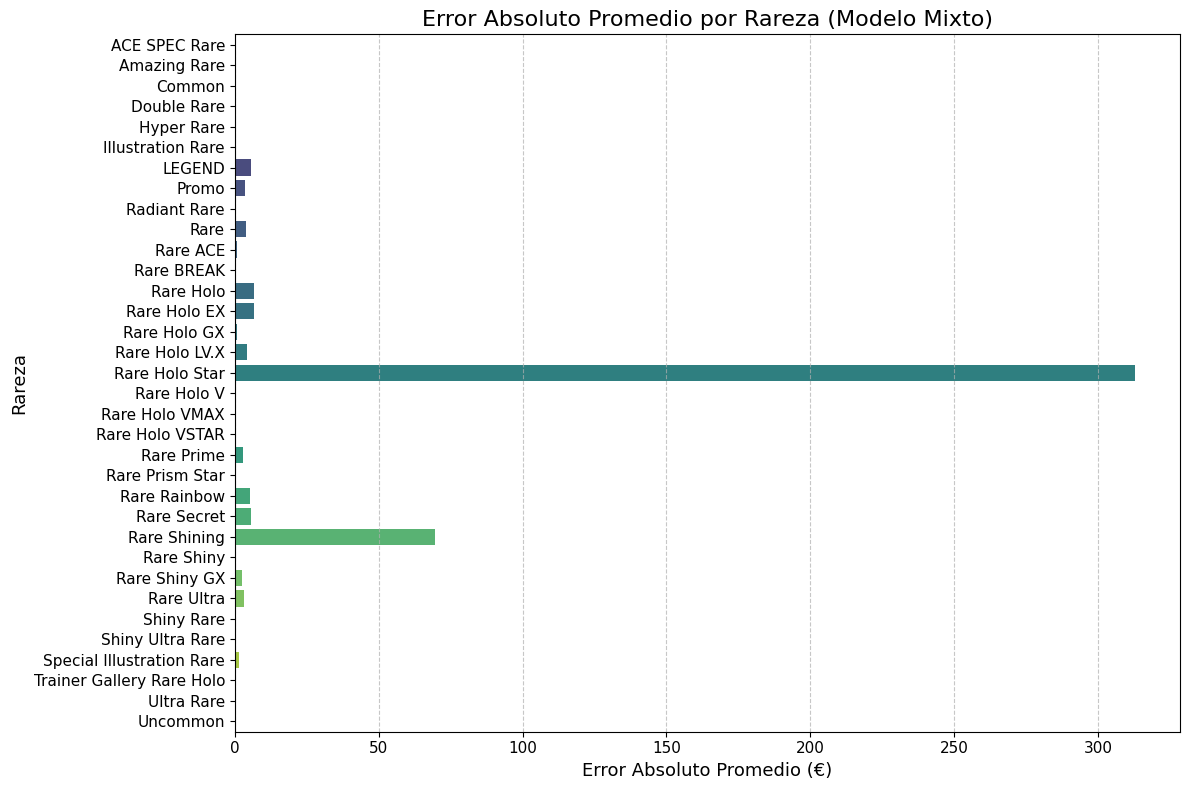


--- Depuración para Gráfico de Error por Set ---
Número total de sets únicos antes de filtrar: 152

Número de sets después de filtrar por Numero_de_Cartas >= 5: 152

DataFrame 'set_error_top15' que se usará para graficar:
                            Error_Absoluto_Promedio  Numero_de_Cartas
set_name                                                             
POP Series 5                             477.602200                17
Base                                      61.679165               102
Nintendo Black Star Promos                27.371038                40
Team Rocket Returns                       21.909028               111
Wizards Black Star Promos                 19.620983                53
Delta Species                             17.426495               114
Deoxys                                    15.698707               108
Holon Phantoms                            14.560398               111
Best of Game                              12.135023                 9
Neo Des

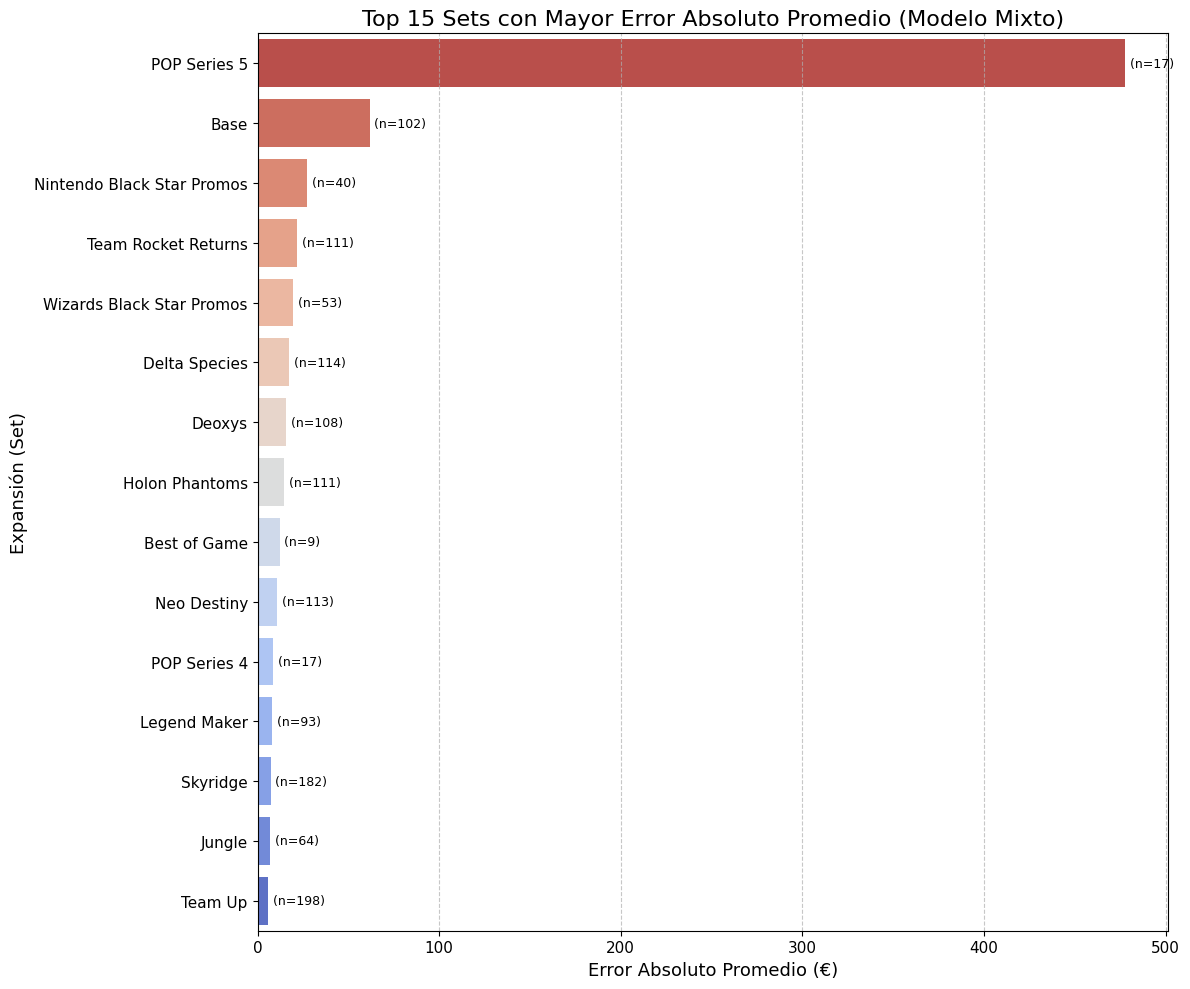

In [84]:
# Celda para Visualización de Errores del Modelo Mixto (Corregida v2)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Asegurarse de que todas las variables necesarias están disponibles
# Estas variables deben estar definidas en celdas anteriores:
# df_model_final: DataFrame que contiene all_features y target_col (precio real)
# X: DataFrame con all_features (usado para y_pred_mixed)
# y: Series con el target_col (precio real, alineado con X)
# y_pred_mixed: Series con las predicciones del modelo mixto (alineado con X e y)
# target_col: string, nombre de la columna objetivo (ej. 'precio')

if 'df_model_final' not in locals() or df_model_final.empty:
    print("ERROR: df_model_final no está definido o está vacío. No se pueden generar gráficos.")
elif 'X' not in locals() or X.empty:
    print("ERROR: X no está definido o está vacío. No se pueden generar gráficos.")
elif 'y' not in locals() or y.empty:
    print("ERROR: y no está definido o está vacío. No se pueden generar gráficos.")
elif 'y_pred_mixed' not in locals() or y_pred_mixed.empty:
    print("ERROR: y_pred_mixed no está definido o está vacío. Ejecuta la celda de predicción mixta primero.")
elif 'target_col' not in locals():
    print("ERROR: La variable 'target_col' (nombre de la columna objetivo) no está definida.")
else:
    print("\n--- Preparando datos para visualización de errores del modelo mixto ---")

    # 1. Crear df_resultado con las características originales, el precio real y las predicciones
    # Usamos el índice de y_pred_mixed para asegurar la alineación, ya que y_pred_mixed
    # podría no cubrir todos los índices de df_model_final si hubo NaNs en cm_avg7.
    # Tomamos las columnas necesarias de df_model_final para esas filas.

    # Asegurar que y_pred_mixed sea una Series (ya debería serlo)
    if not isinstance(y_pred_mixed, pd.Series):
        try:
            y_pred_mixed = pd.Series(y_pred_mixed, index=X.index) # Intentar alinear con X si es un array
        except Exception as e_series:
            print(f"Error convirtiendo y_pred_mixed a Series: {e_series}. No se puede continuar.")
            y_pred_mixed = pd.Series(dtype=float) # Crear Series vacía para evitar más errores

    if not y_pred_mixed.empty:
        # Tomar las columnas de df_model_final usando el índice de y_pred_mixed
        # Esto asegura que solo tomemos las filas para las cuales tenemos predicciones.
        df_resultado = df_model_final.loc[y_pred_mixed.index, ['rarity', 'set_name', target_col]].copy()
        df_resultado.rename(columns={target_col: 'Precio Real'}, inplace=True)
        df_resultado["Precio Estimado"] = y_pred_mixed

        # Eliminar filas donde la predicción o el precio real sean NaN
        # (y_pred_mixed podría tener NaNs si alguna máscara en predict_mixed no se aplicó a todas las filas)
        df_resultado.dropna(subset=['Precio Real', 'Precio Estimado'], inplace=True)
        print(f"Shape de df_resultado después de añadir predicciones y dropna: {df_resultado.shape}")
    else:
        print("ERROR: y_pred_mixed está vacío o no se pudo alinear. No se puede crear df_resultado.")
        df_resultado = pd.DataFrame()


    if df_resultado.empty:
        print("ERROR: df_resultado está vacío después de intentar añadir predicciones. Verifica la alineación de X, y, y_pred_mixed.")
    else:
        # Calcular columnas de error
        df_resultado["Diferencia (€)"] = df_resultado["Precio Real"] - df_resultado["Precio Estimado"]
        df_resultado["Error Absoluto (€)"] = np.abs(df_resultado["Diferencia (€)"])
        df_resultado["Error (%)"] = np.where(
            df_resultado["Precio Real"] != 0,
            (df_resultado["Diferencia (€)"] / df_resultado["Precio Real"]) * 100,
            np.nan
        )
        print("Primeras filas de df_resultado con errores calculados:")
        print(df_resultado.head().to_string())

        # 1. Error absoluto promedio por rareza
        if 'rarity' in df_resultado.columns:
            rareza_error = df_resultado.groupby("rarity", observed=False)["Error Absoluto (€)"].mean().sort_values(ascending=False)

            if not rareza_error.empty:
                # Limpieza explícita de figura y ejes
                plt.figure().clear()
                plt.close('all') # Cierra todas las figuras previas
                # plt.cla() # No es necesario si creamos nuevos ejes con subplots
                # plt.clf() # No es necesario si creamos nueva figura con subplots

                fig, ax = plt.subplots(figsize=(12, 8))
                sns.barplot(
                    x=rareza_error.values,
                    y=rareza_error.index,
                    hue=rareza_error.index,
                    palette="viridis",
                    legend=False,
                    orient='h',
                    ax=ax
                )
                ax.set_title("Error Absoluto Promedio por Rareza (Modelo Mixto)", fontsize=16)
                ax.set_xlabel("Error Absoluto Promedio (€)", fontsize=13)
                ax.set_ylabel("Rareza", fontsize=13)
                ax.tick_params(axis='x', labelsize=11)
                ax.tick_params(axis='y', labelsize=11)
                ax.grid(axis='x', linestyle='--', alpha=0.7)
                fig.tight_layout()
                plt.show()
            else:
                print("No hay datos para graficar el error por rareza.")
        else:
            print("Advertencia: La columna 'rarity' no está en df_resultado.")


        # 2. Top 15 sets con mayor error absoluto promedio
        if 'set_name' in df_resultado.columns:
            print("\n--- Depuración para Gráfico de Error por Set ---")
            set_error_full = df_resultado.groupby("set_name", observed=False)["Error Absoluto (€)"].agg(
                Error_Absoluto_Promedio='mean',
                Numero_de_Cartas='count'
            )
            print(f"Número total de sets únicos antes de filtrar: {len(set_error_full)}")

            min_cards_per_set = 5
            set_error_filtered = set_error_full[set_error_full['Numero_de_Cartas'] >= min_cards_per_set].copy()
            print(f"\nNúmero de sets después de filtrar por Numero_de_Cartas >= {min_cards_per_set}: {len(set_error_filtered)}")

            if not set_error_filtered.empty:
                set_error_top15 = set_error_filtered.sort_values(by="Error_Absoluto_Promedio", ascending=False).head(15)
                print("\nDataFrame 'set_error_top15' que se usará para graficar:")
                print(set_error_top15.to_string())

                if not set_error_top15.empty:
                    # Limpieza explícita de figura y ejes ANTES de crear el nuevo gráfico
                    plt.figure().clear()
                    plt.close('all')

                    fig, ax = plt.subplots(figsize=(12, 10))

                    # Convertir el índice (nombres de set) a una lista de strings
                    y_labels = list(set_error_top15.index)
                    x_values = set_error_top15["Error_Absoluto_Promedio"].values

                    sns.barplot(
                        x=x_values,
                        y=y_labels,
                        hue=y_labels, # Para que palette aplique colores diferentes a cada barra
                        palette="coolwarm_r",
                        legend=False, # No necesitamos leyenda si hue es lo mismo que y
                        orient='h',
                        ax=ax
                    )
                    ax.set_title("Top 15 Sets con Mayor Error Absoluto Promedio (Modelo Mixto)", fontsize=16)
                    ax.set_xlabel("Error Absoluto Promedio (€)", fontsize=13)
                    ax.set_ylabel("Expansión (Set)", fontsize=13)
                    ax.tick_params(axis='x', labelsize=11)
                    ax.tick_params(axis='y', labelsize=11)
                    ax.grid(axis='x', linestyle='--', alpha=0.7)

                    # Anotaciones
                    for i, set_name_in_plot in enumerate(y_labels):
                        error_value = set_error_top15.loc[set_name_in_plot, "Error_Absoluto_Promedio"]
                        count_value = set_error_top15.loc[set_name_in_plot, "Numero_de_Cartas"]

                        ax.text(error_value + 0.5,
                                 i,
                                 f' (n={int(count_value)})',
                                 color='black',
                                 ha="left",
                                 va="center",
                                 fontsize=9)

                    fig.tight_layout()
                    plt.show()
                else:
                    print("DataFrame 'set_error_top15' está vacío (después de .head(15)). No se puede generar el gráfico.")
            else:
                print(f"No hay sets que cumplan el criterio de tener al menos {min_cards_per_set} cartas. No se puede generar el gráfico de error por set.")
        else:
            print("Advertencia: La columna 'set_name' no está en df_resultado.")


--- Generando visualizaciones adicionales usando df_resultado (Shape: (18462, 7)) ---

Generando gráfico: Distribución del Error Absoluto...


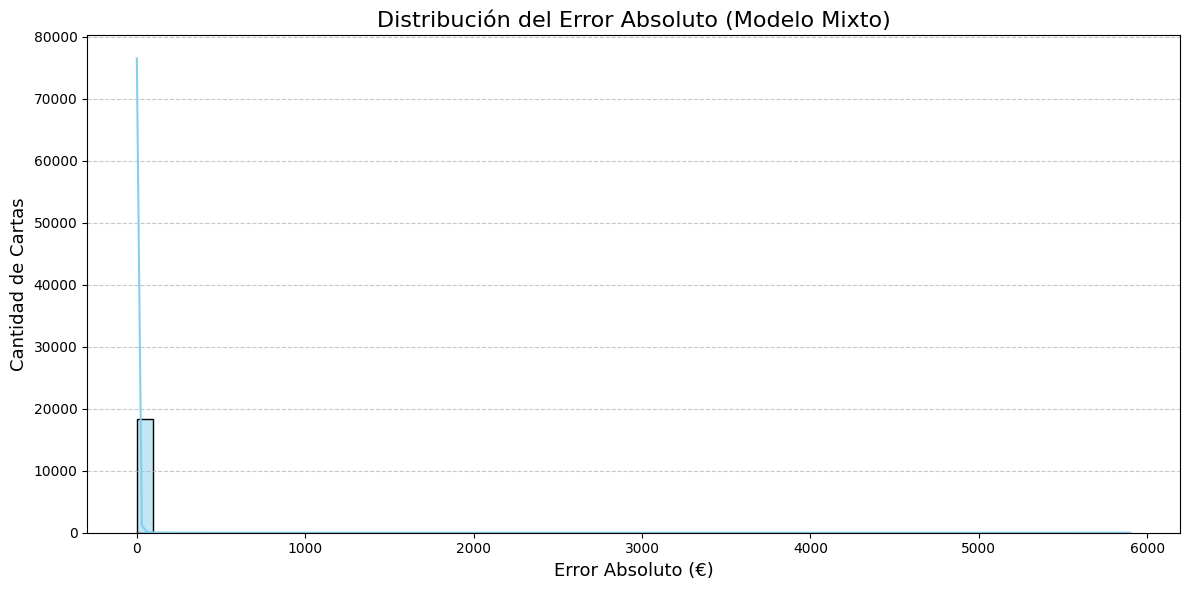


Generando gráfico: Boxplot de Error Absoluto por Rareza...


<ipython-input-60-c27f56860710>:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


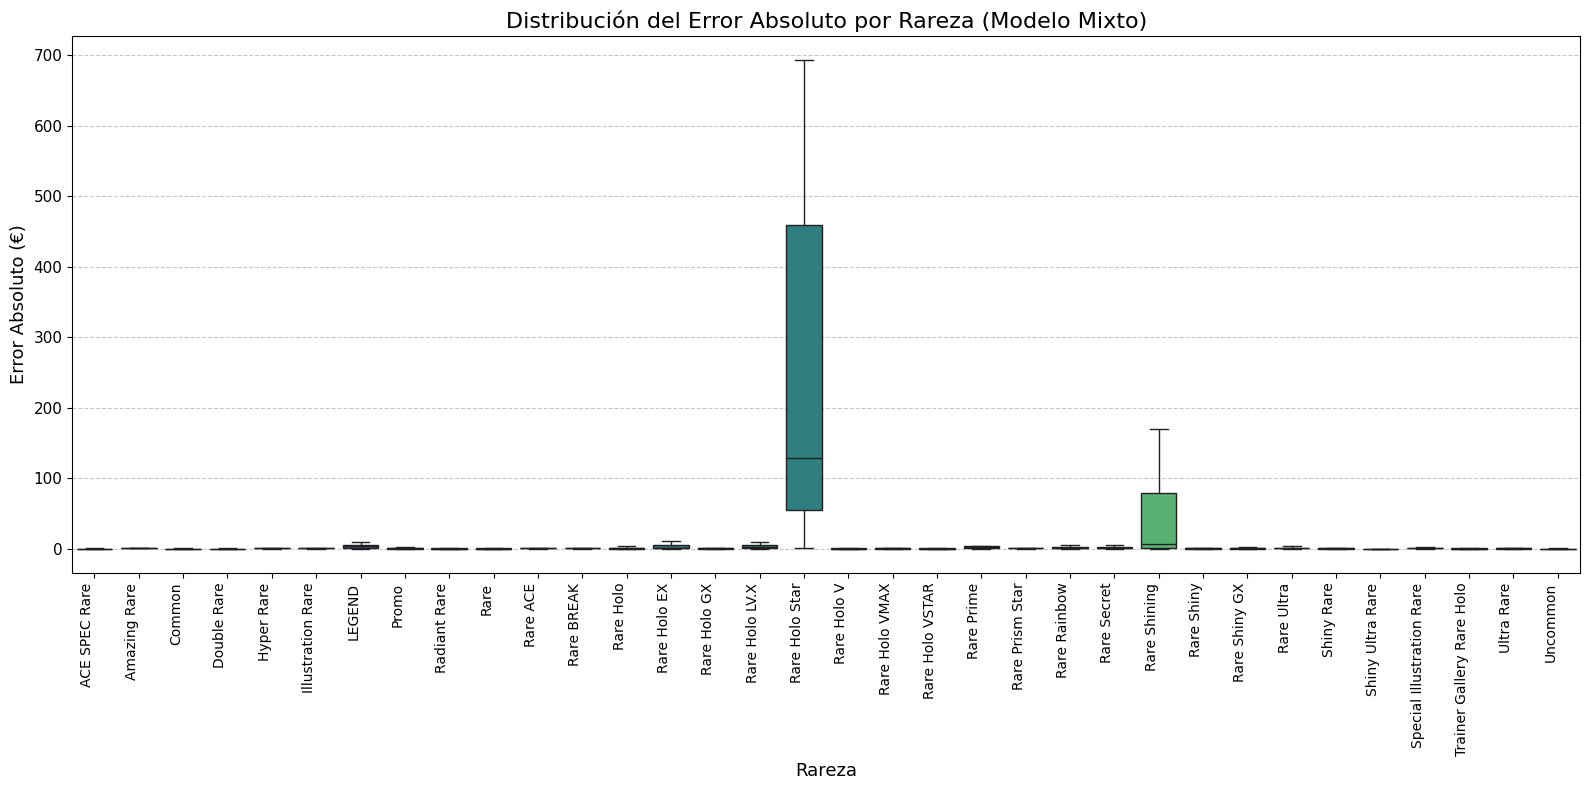


Generando gráfico: Cantidad de Cartas por Rareza...


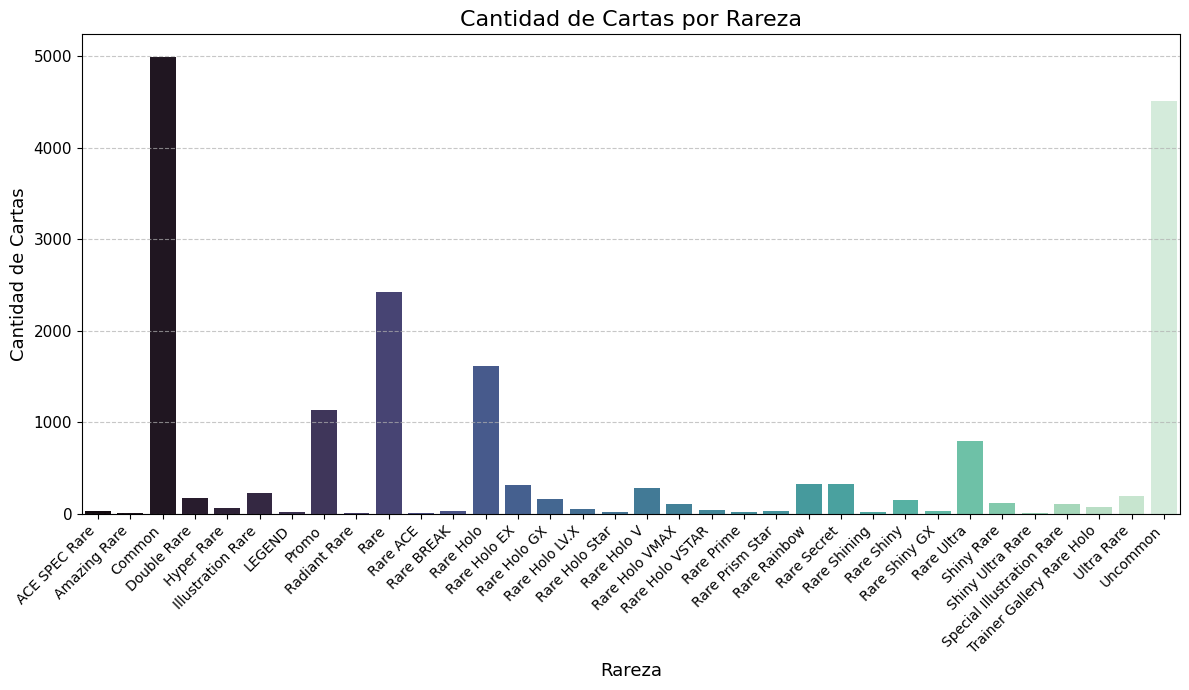

In [60]:
# Celda para Visualizaciones Adicionales de Error y Distribución

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Asumimos que las siguientes variables ya están definidas y pobladas desde celdas anteriores:
# df_resultado: DataFrame con columnas 'rarity', 'Error Absoluto (€)'

if 'df_resultado' not in locals() or df_resultado.empty:
    print("ERROR: df_resultado no está definido o está vacío. No se pueden generar los gráficos.")
    print("Asegúrate de haber ejecutado la celda anterior que calcula df_resultado.")
else:
    print(f"\n--- Generando visualizaciones adicionales usando df_resultado (Shape: {df_resultado.shape}) ---")

    # 1. Distribución del error absoluto
    if "Error Absoluto (€)" in df_resultado.columns:
        print("\nGenerando gráfico: Distribución del Error Absoluto...")
        # Limpieza explícita de figura
        plt.figure().clear()
        plt.close('all')

        plt.figure(figsize=(12, 6)) # Ajustar tamaño
        sns.histplot(df_resultado["Error Absoluto (€)"], bins=60, kde=True, color="skyblue")
        plt.title("Distribución del Error Absoluto (Modelo Mixto)", fontsize=16)
        plt.xlabel("Error Absoluto (€)", fontsize=13)
        plt.ylabel("Cantidad de Cartas", fontsize=13)

        # Ajustar xlim dinámicamente o quitarlo si los errores son muy grandes
        # Para un xlim fijo:
        # plt.xlim(0, 10)
        # Para un xlim dinámico basado en percentiles (excluyendo outliers extremos para la visualización):
        # upper_limit = np.percentile(df_resultado["Error Absoluto (€)"].dropna(), 99) # Ver el 99% de los datos
        # plt.xlim(0, upper_limit if upper_limit > 0 else 10) # Si el percentil es 0, usar 10 por defecto

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("Advertencia: La columna 'Error Absoluto (€)' no está en df_resultado.")


    # 2. Boxplot de error absoluto por rareza (sin superposición)
    if 'rarity' in df_resultado.columns and "Error Absoluto (€)" in df_resultado.columns:
        print("\nGenerando gráfico: Boxplot de Error Absoluto por Rareza...")
        # Limpieza explícita de figura
        plt.figure().clear()
        plt.close('all')

        # Ordenar rarezas por error absoluto mediano para mejor visualización (opcional)
        # order = df_resultado.groupby('rarity', observed=False)['Error Absoluto (€)'].median().sort_values().index

        plt.figure(figsize=(16, 8))  # Más ancho y un poco más alto
        # --- MODIFICACIÓN PARA FUTUREWARNING (si aplica a boxplot con palette) ---
        # No hay 'hue' directo en boxplot para colorear cada caja de forma diferente con 'palette'
        # Se colorearán según el orden por defecto de la paleta si se usa 'palette'.
        # Si quieres colores específicos por rareza, necesitarías un mapeo y pasar 'color' a cada caja.
        sns.boxplot(
            data=df_resultado,
            x="rarity",
            y="Error Absoluto (€)",
            showfliers=False, # Ocultar outliers para mejor visualización general
            # order=order, # Descomentar si quieres ordenar las rarezas
            palette="viridis" # Ejemplo de paleta
        )
        plt.title("Distribución del Error Absoluto por Rareza (Modelo Mixto)", fontsize=16)
        plt.xlabel("Rareza", fontsize=13)
        plt.ylabel("Error Absoluto (€)", fontsize=13)
        plt.xticks(rotation=90, ha='right', fontsize=10) # Rotar y alinear a la derecha
        plt.yticks(fontsize=11)

        # Ajustar y_lim para enfocarse en la mayoría de los datos (sin fliers)
        # upper_boxplot_limit = np.percentile(df_resultado["Error Absoluto (€)"].dropna(), 98)
        # plt.ylim(0, upper_boxplot_limit if upper_boxplot_limit > 0 else 50) # Ajustar según tus datos

        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout() # Muy importante para que las etiquetas no se corten
        plt.show()
    else:
        print("Advertencia: Las columnas 'rarity' o 'Error Absoluto (€)' no están en df_resultado.")


    # 3. Cantidad de cartas por rareza
    if 'rarity' in df_resultado.columns:
        print("\nGenerando gráfico: Cantidad de Cartas por Rareza...")
        # Limpieza explícita de figura
        plt.figure().clear()
        plt.close('all')

        plt.figure(figsize=(12, 7))
        # --- MODIFICACIÓN PARA FUTUREWARNING (si aplica a value_counts().plot) ---
        # value_counts() ya no tendrá 'observed' por defecto, pero para groupby sí es relevante
        counts_by_rarity = df_resultado["rarity"].value_counts()

        # Usar Seaborn para un barplot más consistente si se desea
        sns.barplot(
            x=counts_by_rarity.index,
            y=counts_by_rarity.values,
            hue=counts_by_rarity.index, # Para que palette funcione bien en versiones recientes
            palette="mako",             # Ejemplo de paleta
            legend=False
        )
        # O mantener el plot de Pandas:
        # counts_by_rarity.plot(kind='bar', color=sns.color_palette("mako", len(counts_by_rarity)))

        plt.title("Cantidad de Cartas por Rareza", fontsize=16)
        plt.xlabel("Rareza", fontsize=13)
        plt.ylabel("Cantidad de Cartas", fontsize=13)
        plt.xticks(rotation=45, ha='right', fontsize=10) # Rotar menos para mejor legibilidad
        plt.yticks(fontsize=11)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("Advertencia: La columna 'rarity' no está en df_resultado.")


In [89]:
# Celda para Crear df_resultado y Análisis de Errores (Corregida v2)

import pandas as pd
import numpy as np
# from IPython.display import display # Descomentar si estás en un entorno Jupyter/Colab y quieres salida HTML

# --- Variables que deben estar definidas desde celdas anteriores ---
# df_model_final: DataFrame que contiene todas las features (incluyendo 'cm_avg7'),
#                 el target_col (ej. 'precio'), 'card_id', 'pokemon_name' (nombre original para display),
#                 'set_name', 'rarity'.
# X:              df_model_final[all_features_for_model] (usado para entrenar y obtener y_pred_mixed)
# y_pred_mixed:   pd.Series con las predicciones del modelo mixto, idealmente con el mismo índice que X.
# target_col:     Nombre de la columna objetivo en df_model_final (ej. 'precio').
# all_features_for_model: Lista de features usadas por el modelo.

if 'df_model_final' not in locals() or df_model_final.empty:
    print("ERROR: df_model_final no está definido o está vacío. No se puede continuar.")
elif 'y_pred_mixed' not in locals() or y_pred_mixed.empty:
    print("ERROR: y_pred_mixed no está definido o está vacío. Ejecuta la celda de predicción mixta primero.")
elif 'target_col' not in locals() or not target_col:
    print("ERROR: La variable 'target_col' (nombre de la columna objetivo) no está definida.")
elif 'pokemon_name' not in df_model_final.columns: # 'pokemon_name' es el nombre original de la carta
    print("ERROR: La columna 'pokemon_name' (nombre original de la carta) no se encuentra en df_model_final.")
else:
    print("\n--- Creando df_resultado con predicciones y errores del modelo mixto ---")

    # 1. Crear df_resultado a partir de df_model_final, usando el índice de y_pred_mixed
    #    para asegurar que solo tomemos las filas para las cuales tenemos predicciones.
    #    Columnas necesarias: 'pokemon_name', 'set_name', 'rarity', y el target_col.

    if not isinstance(y_pred_mixed, pd.Series):
        print("ADVERTENCIA: y_pred_mixed no es una Series de Pandas. Intentando convertir...")
        try:
            # Si y_pred_mixed se generó a partir de X, sus índices deberían coincidir
            y_pred_mixed = pd.Series(y_pred_mixed, index=X.index, name="Precio Estimado")
            print("INFO: y_pred_mixed convertido a Series con el índice de X.")
        except Exception as e_series_conv:
            print(f"ERROR: No se pudo convertir y_pred_mixed a Series con el índice de X: {e_series_conv}")
            # Crear un df_resultado vacío para evitar más errores, pero el análisis no será posible.
            df_resultado = pd.DataFrame()

    if isinstance(y_pred_mixed, pd.Series) and not y_pred_mixed.empty:
        # Seleccionar las columnas de df_model_final usando el índice de y_pred_mixed
        # Asegurarse de que target_col y otras columnas de metadatos existan
        cols_to_select_from_df_model_final = ['pokemon_name', 'set_name', 'rarity', target_col]
        # Verificar si estas columnas existen
        actual_cols_present = [col for col in cols_to_select_from_df_model_final if col in df_model_final.columns]

        if len(actual_cols_present) != len(cols_to_select_from_df_model_final):
            print(f"ADVERTENCIA: No todas las columnas esperadas ({cols_to_select_from_df_model_final}) "
                  f"están en df_model_final. Columnas encontradas: {actual_cols_present}")

        df_resultado = df_model_final.loc[y_pred_mixed.index, actual_cols_present].copy()
        df_resultado.rename(columns={target_col: 'Precio Real'}, inplace=True)
        df_resultado["Precio Estimado"] = y_pred_mixed

        # Eliminar filas donde el precio real o estimado sea NaN
        df_resultado.dropna(subset=['Precio Real', 'Precio Estimado'], inplace=True)
        print(f"Shape de df_resultado después de añadir predicciones y dropna: {df_resultado.shape}")
    else:
        if not isinstance(y_pred_mixed, pd.Series): # Si la conversión anterior falló
            pass # El error ya se imprimió
        else: # Si y_pred_mixed era una Series pero vacía
            print("ERROR: y_pred_mixed está vacío. No se puede crear df_resultado.")
        df_resultado = pd.DataFrame()


    if df_resultado.empty:
        print("ERROR: df_resultado está vacío. No se puede proceder con el análisis de errores.")
    else:
        # 2. Calcular diferencias y errores
        df_resultado["Diferencia (€)"] = df_resultado["Precio Real"] - df_resultado["Precio Estimado"]
        df_resultado["Error Absoluto (€)"] = np.abs(df_resultado["Diferencia (€)"])
        df_resultado["Error (%)"] = np.where(
            df_resultado["Precio Real"] != 0,
            (df_resultado["Diferencia (€)"] / df_resultado["Precio Real"]) * 100,
            np.nan
        )

        print("\nPrimeras filas de df_resultado con errores:")
        # Usar to_string() para que Colab muestre más filas/columnas si es necesario
        print(df_resultado.head().to_string())

        print("\nDescripción de columnas de error:")
        print(df_resultado[["Diferencia (€)", "Error Absoluto (€)", "Error (%)"]].describe().to_string())

        # ANÁLISIS DE ERRORES (secciones 1 a 5 del código original)
        # 1. Top 5 sets con mayor error absoluto promedio
        if 'set_name' in df_resultado.columns and 'Error Absoluto (€)' in df_resultado.columns:
            top_sets = df_resultado.groupby("set_name", observed=False)["Error Absoluto (€)"].mean().sort_values(ascending=False).head(5)
            top_sets_names = top_sets.index.tolist()

            print("\n📦 Top 5 Sets con Mayor Error Absoluto Promedio:\n")
            print(top_sets.to_string())

            # 2. ¿Cuántas cartas tiene cada uno de estos top sets?
            if top_sets_names:
                print("\n🔢 Número de Cartas por Set (de los Top 5 con Mayor Error):")
                counts_in_top_sets = df_resultado[df_resultado["set_name"].isin(top_sets_names)]["set_name"].value_counts()
                # Para mostrar en el orden de top_sets, reindexamos
                if not counts_in_top_sets.empty and all(name in counts_in_top_sets.index for name in top_sets_names):
                     print(counts_in_top_sets.reindex(top_sets_names).fillna(0).astype(int).to_string())
                elif not counts_in_top_sets.empty:
                     print(counts_in_top_sets.to_string()) # Mostrar como está si hay problemas con reindex
                else:
                     print("No hay conteos para los top sets.")

            else:
                print("No hay 'top_sets_names' para mostrar conteos.")


            # 4. Rarezas presentes en cada uno de estos top sets
            if top_sets_names and 'rarity' in df_resultado.columns:
                print("\n🌟 Rarezas Más Frecuentes por Set (de los Top 5 con Mayor Error):")
                # Filtrar df_resultado antes del groupby
                rareza_por_set = df_resultado[df_resultado["set_name"].isin(top_sets_names)].groupby(["set_name", "rarity"], observed=False).size().unstack(fill_value=0)
                # Reindexar para que los sets aparezcan en el orden de top_sets
                if not rareza_por_set.empty and all(name in rareza_por_set.index for name in top_sets_names):
                    print(rareza_por_set.reindex(top_sets_names).fillna(0).astype(int).to_string())
                elif not rareza_por_set.empty:
                    print(rareza_por_set.to_string())
                else:
                    print("No hay datos de rareza para los top sets.")
            else:
                print("No hay 'top_sets_names' o 'rarity' para mostrar distribución de rarezas.")

            # 5. Cartas con mayor error en esos top 5 sets problemáticos
            # 'pokemon_name' ya debería estar en df_resultado
            if 'pokemon_name' not in df_resultado.columns:
                print(f"ADVERTENCIA: La columna 'pokemon_name' no está en df_resultado para el reporte de errores altos.")
                df_resultado['pokemon_name'] = "Nombre No Disponible" # Placeholder

            if top_sets_names and 'Error Absoluto (€)' in df_resultado.columns and 'Precio Estimado' in df_resultado.columns:
                print("\n🔍 Top 10 Cartas con Mayor Error Absoluto en los Sets Problemáticos:")
                errores_altos = df_resultado[df_resultado["set_name"].isin(top_sets_names)].sort_values(by="Error Absoluto (€)", ascending=False).head(10)

                cols_to_show_errores_altos = [
                    'pokemon_name', 'set_name', 'rarity', # Usar 'pokemon_name'
                    'Precio Real', 'Precio Estimado', 'Error Absoluto (€)'
                ]
                cols_existentes_errores_altos = [col for col in cols_to_show_errores_altos if col in errores_altos.columns]

                print(errores_altos[cols_existentes_errores_altos].to_string())
            else:
                print("No se pueden mostrar las cartas con errores altos debido a datos faltantes.")
        else:
            print("Advertencia: La columna 'set_name' o 'Error Absoluto (€)' no está en df_resultado para el análisis de sets.")


--- Creando df_resultado con predicciones y errores del modelo mixto ---
Shape de df_resultado después de añadir predicciones y dropna: (18462, 5)

Primeras filas de df_resultado con errores:
       pokemon_name set_name     rarity  Precio Real  Precio Estimado  Diferencia (€)  Error Absoluto (€)  Error (%)
1          Alakazam     Base  Rare Holo       109.99       116.489166       -6.499166            6.499166  -5.908870
3            Mewtwo     Base  Rare Holo        42.48        58.146053      -15.666053           15.666053 -36.878656
5  Lightning Energy     Base     Common         1.10         1.074553        0.025447            0.025447   2.313359
7    Psychic Energy     Base     Common         0.30         0.338156       -0.038156            0.038156 -12.718609
9      Water Energy     Base     Common         0.35         0.366576       -0.016576            0.016576  -4.736038

Descripción de columnas de error:
       Diferencia (€)  Error Absoluto (€)     Error (%)
count    18462


--- Generando visualizaciones detalladas para los top 5 sets con mayor error ---
Shape de df_top_sets: (323, 8)

Generando gráfico: Distribución del Error Absoluto en Sets Problemáticos...


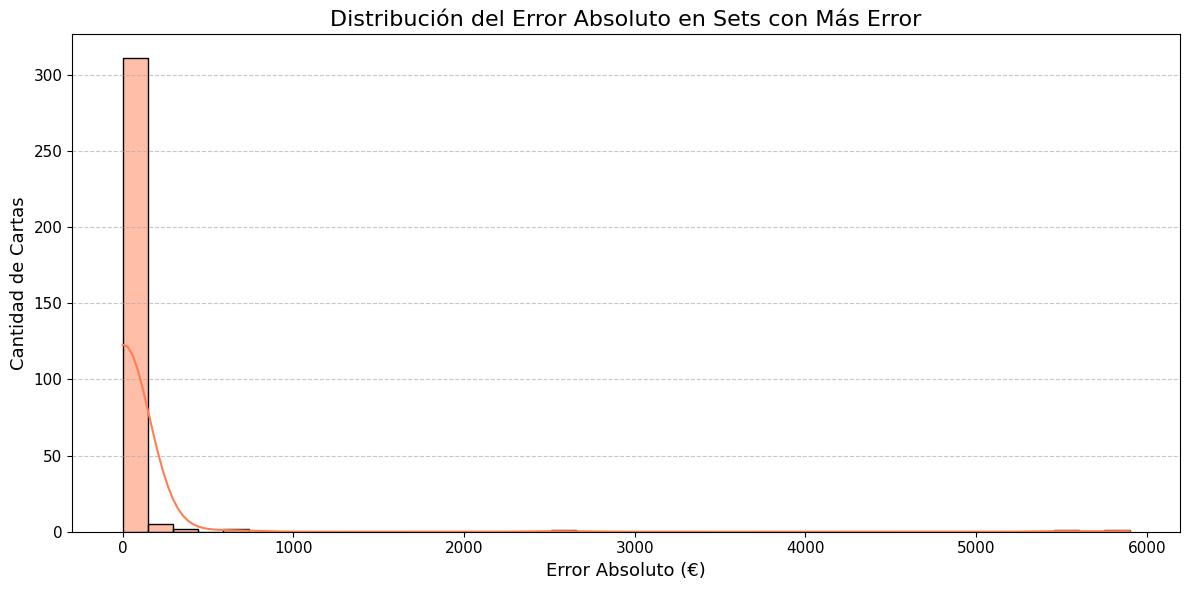


Generando gráfico: Rarezas Presentes en Sets con Más Error (Apilado)...


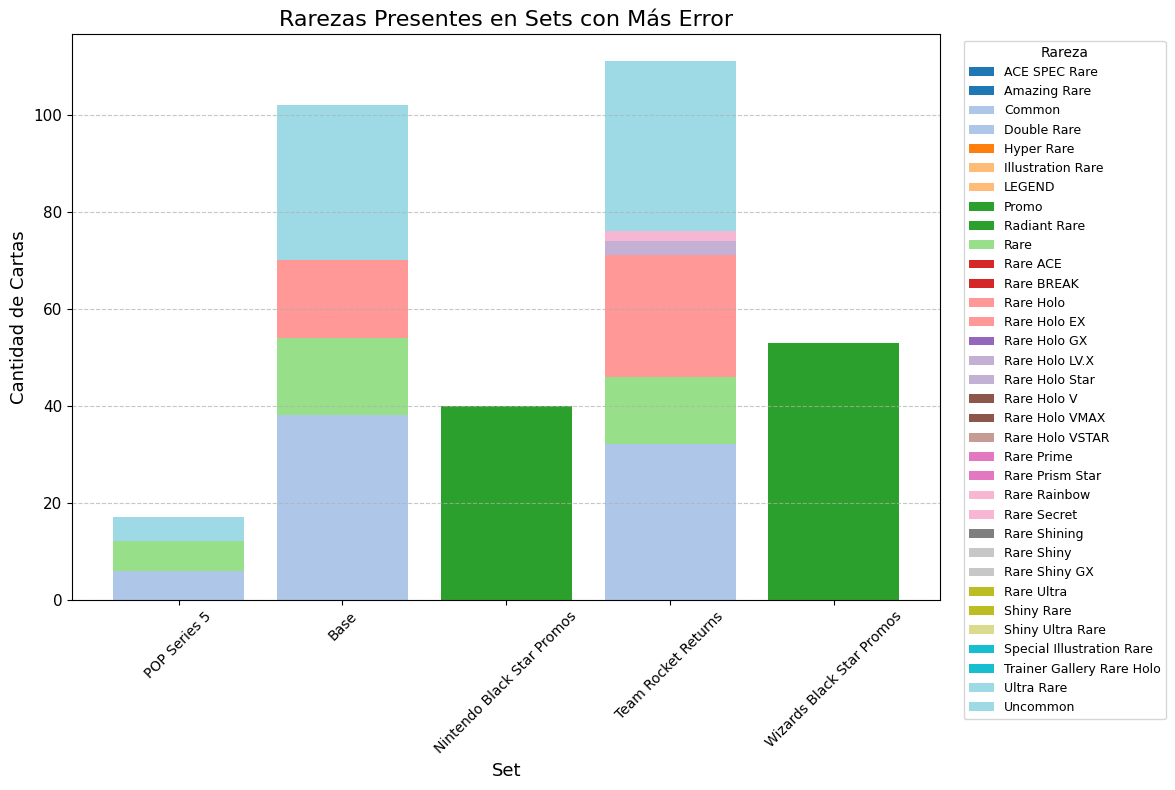


Generando gráfico: Scatterplot Precio Real vs. Estimado por Set Problemático...


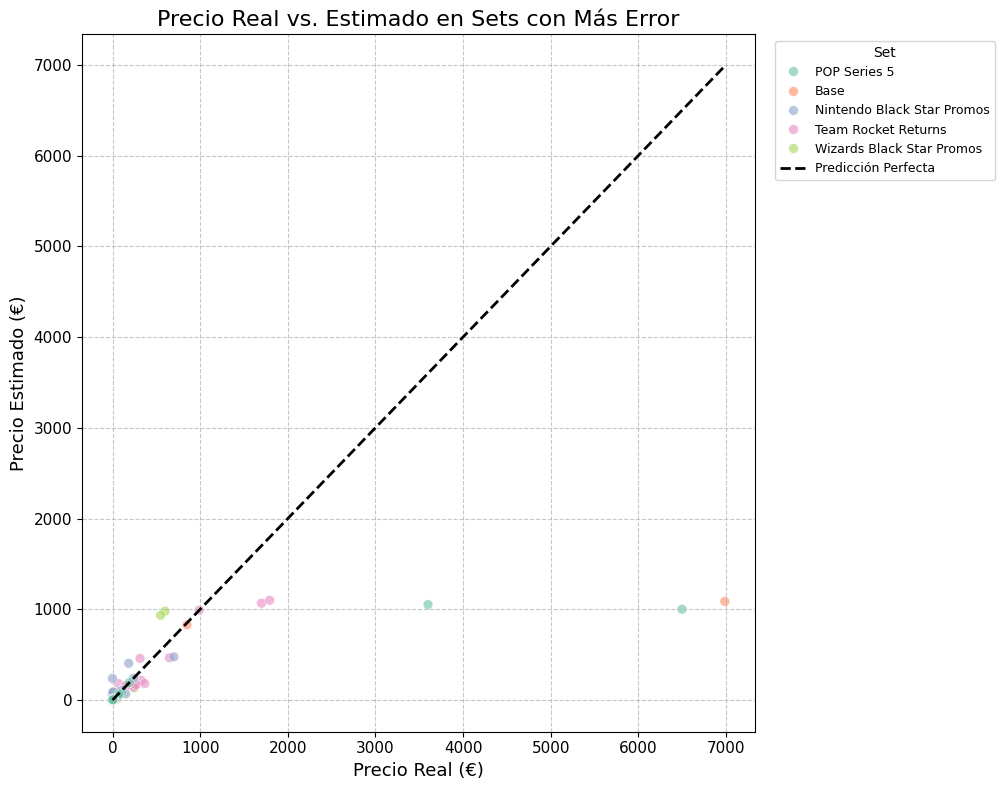

In [65]:
# Celda para Visualización Detallada de Sets con Mayor Error (Corregida v2)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Asumimos que las siguientes variables ya están definidas y pobladas desde celdas anteriores:
# df_resultado: DataFrame con 'set_name', 'rarity', 'Precio Real', 'Precio Estimado', 'Error Absoluto (€)'
# top_sets:     Pandas Series con los nombres de los top N sets (índice) y su error medio (valores)
# target_col:   String con el nombre de la columna de precio real (ej. 'precio')

if 'df_resultado' not in locals() or df_resultado.empty:
    print("ERROR: df_resultado no está definido o está vacío. No se pueden generar los gráficos de sets.")
elif 'top_sets' not in locals() or top_sets.empty:
    print("ERROR: top_sets no está definido o está vacío. Ejecuta la celda de análisis anterior primero.")
elif "Precio Real" not in df_resultado.columns: # Asegurarse que la columna renombrada exista
    print("ERROR: La columna 'Precio Real' no existe en df_resultado. Verifica la creación de df_resultado.")
elif "Precio Estimado" not in df_resultado.columns:
    print("ERROR: La columna 'Precio Estimado' no existe en df_resultado. Verifica la creación de df_resultado.")
elif "Error Absoluto (€)" not in df_resultado.columns:
    print("ERROR: La columna 'Error Absoluto (€)' no existe en df_resultado. Verifica la creación de df_resultado.")
else:
    print(f"\n--- Generando visualizaciones detalladas para los top {len(top_sets)} sets con mayor error ---")

    # Subset de los sets problemáticos
    df_top_sets = df_resultado[df_resultado["set_name"].isin(top_sets.index)].copy()
    print(f"Shape de df_top_sets: {df_top_sets.shape}")

    if df_top_sets.empty:
        print("No hay datos para los top sets seleccionados. No se generarán gráficos.")
    else:



        # 2. Distribución del error absoluto en esos sets problemáticos (combinados)
        if "Error Absoluto (€)" in df_top_sets.columns:
            print("\nGenerando gráfico: Distribución del Error Absoluto en Sets Problemáticos...")
            plt.figure().clear(); plt.close('all')
            fig, ax = plt.subplots(figsize=(12, 6))
            sns.histplot(df_top_sets["Error Absoluto (€)"], bins=40, kde=True, color="coral", ax=ax)
            ax.set_title("Distribución del Error Absoluto en Sets con Más Error", fontsize=16)
            ax.set_xlabel("Error Absoluto (€)", fontsize=13)
            ax.set_ylabel("Cantidad de Cartas", fontsize=13)
            ax.tick_params(labelsize=11)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            fig.tight_layout()
            plt.show()
        else:
            print("Advertencia: La columna 'Error Absoluto (€)' no está en df_top_sets.")


        # 3. Conteo de rarezas por set (gráfico apilado) para los top sets
        if 'set_name' in df_top_sets.columns and 'rarity' in df_top_sets.columns:
            print("\nGenerando gráfico: Rarezas Presentes en Sets con Más Error (Apilado)...")
            plt.figure().clear(); plt.close('all')

            rareza_stacked_top_sets = df_top_sets.groupby(["set_name", "rarity"], observed=False).size().unstack(fill_value=0)

            if not rareza_stacked_top_sets.empty:
                # Reindexar para mantener el orden de top_sets si es deseado
                rareza_stacked_top_sets = rareza_stacked_top_sets.reindex(top_sets.index).dropna(how='all', axis=0) # dropna si algún set no tiene rarezas después de reindexar

                if not rareza_stacked_top_sets.empty: # Comprobar de nuevo después de reindexar
                    ax_stacked = rareza_stacked_top_sets.plot( # Guardar el 'ax' devuelto por plot
                        kind="bar",
                        stacked=True,
                        figsize=(14, 8), # Ajustar tamaño
                        colormap="tab20",
                        width=0.8
                    )
                    ax_stacked.set_title("Rarezas Presentes en Sets con Más Error", fontsize=16)
                    ax_stacked.set_xlabel("Set", fontsize=13)
                    ax_stacked.set_ylabel("Cantidad de Cartas", fontsize=13)
                    ax_stacked.tick_params(axis='x', rotation=45, labelsize=10)
                    # plt.xticks(rotation=45, ha='right', fontsize=10) # Alternativa
                    ax_stacked.tick_params(axis='y', labelsize=11)
                    ax_stacked.grid(axis='y', linestyle='--', alpha=0.7)
                    ax_stacked.legend(title='Rareza', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
                    plt.tight_layout(rect=[0, 0, 0.85, 1])
                    plt.show()
                else:
                    print("No hay datos para el gráfico de rarezas apiladas después de reindexar (quizás los top_sets no están en df_top_sets).")
            else:
                print("No hay datos para el gráfico de rarezas apiladas para los top sets.")
        else:
            print("Advertencia: Las columnas 'set_name' o 'rarity' no están en df_top_sets.")


        # 4. Scatterplot: Precio real vs. Precio estimado, coloreado por set (para los top sets)
        if 'set_name' in df_top_sets.columns and 'Precio Real' in df_top_sets.columns and 'Precio Estimado' in df_top_sets.columns:
            print("\nGenerando gráfico: Scatterplot Precio Real vs. Estimado por Set Problemático...")
            plt.figure().clear(); plt.close('all')
            fig, ax = plt.subplots(figsize=(12, 8))

            hue_order = top_sets.index.tolist()

            sns.scatterplot(
                data=df_top_sets,
                x="Precio Real",
                y="Precio Estimado",
                hue="set_name",
                hue_order=hue_order,
                alpha=0.6,
                palette="Set2",
                s=50,
                ax=ax
            )

            min_val = min(df_top_sets["Precio Real"].min(), df_top_sets["Precio Estimado"].min())
            max_val = max(df_top_sets["Precio Real"].max(), df_top_sets["Precio Estimado"].max())
            # Asegurarse de que min_val y max_val no sean NaN si los dataframes están vacíos
            if pd.isna(min_val) or pd.isna(max_val):
                min_val, max_val = 0, 100 # Valores por defecto si los datos son problemáticos

            ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label="Predicción Perfecta")

            ax.set_title("Precio Real vs. Estimado en Sets con Más Error", fontsize=16)
            ax.set_xlabel("Precio Real (€)", fontsize=13)
            ax.set_ylabel("Precio Estimado (€)", fontsize=13)
            ax.tick_params(labelsize=11)
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(title="Set", bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
            fig.tight_layout(rect=[0, 0, 0.85, 1])
            plt.show()
        else:
            print("Advertencia: Columnas necesarias para scatterplot no encontradas en df_top_sets.")

In [98]:
# Celda con la DEFINICIÓN de test_set_future (Corregida v5)

def test_set_future(
    set_name_to_test: str,
    df_data_for_model: pd.DataFrame, # Este será df_model_final
    features_for_model_list: list,   # Esta será all_features
    price_target_col: str,
    prediction_func: callable,
    threshold_value: float,
    original_metadata_df: pd.DataFrame # Este será df_meta
):
    print(f"\n--- Analizando proyecciones para el set: {set_name_to_test} ---")

    df_set_current = df_data_for_model[df_data_for_model['set_name'] == set_name_to_test].copy()

    # 'pokemon_name' en features_for_model_list es la que usa el OHE.
    # Para el display, queremos el 'pokemon_name' original de df_meta.
    # df_data_for_model (y por ende df_set_current) YA DEBERÍA TENER 'pokemon_name'
    # si se incluyó en cols_to_keep_in_df_model_final en la Celda 1.
    # Lo que necesitamos es una columna separada para el nombre original si es diferente
    # o si queremos asegurar que no se modifique la que usa el modelo.

    # Crear 'display_name' a partir del 'pokemon_name' de original_metadata_df (df_meta)
    # Esto asegura que usamos el nombre original de la carta, no necesariamente el
    # que se usó para el OHE si hubiera alguna transformación.
    if 'card_id' in df_set_current.columns and not original_metadata_df.empty and 'pokemon_name' in original_metadata_df.columns:
        name_map_df = original_metadata_df[['card_id', 'pokemon_name']].drop_duplicates(subset=['card_id'])
        # Guardar el índice antes del merge
        original_index = df_set_current.index
        df_set_current = pd.merge(df_set_current, name_map_df.rename(columns={'pokemon_name': 'display_name_from_meta'}), on='card_id', how='left')
        # Restaurar índice si el merge lo cambió
        if not df_set_current.index.equals(original_index) and len(df_set_current) == len(original_index):
             df_set_current.index = original_index
        df_set_current['display_name_from_meta'].fillna('Nombre Desconocido (Meta)', inplace=True)
        print("INFO: Columna 'display_name_from_meta' añadida/actualizada desde metadatos originales.")
    else:
        df_set_current['display_name_from_meta'] = df_set_current.get('pokemon_name', 'Nombre Desconocido (Fallback)')
        print("ADVERTENCIA: No se pudo obtener 'display_name_from_meta' de metadatos originales, usando 'pokemon_name' de df_set_current o fallback.")


    # Asegurar que 'pokemon_name' (la que usa el modelo) exista
    if 'pokemon_name' not in df_set_current.columns:
        print(f"❌ ERROR CRÍTICO: La columna 'pokemon_name' (necesaria para el modelo) no está en df_set_current para el set '{set_name_to_test}'.")
        print(f"   Columnas disponibles en df_set_current: {df_set_current.columns.tolist()}")
        return # No podemos continuar sin la feature 'pokemon_name' para el modelo


    cols_to_check_for_na = ['cm_avg7', 'cm_avg30', price_target_col] + features_for_model_list
    cols_to_check_for_na = list(set(cols_to_check_for_na))
    missing_cols_in_df_set = [col for col in cols_to_check_for_na if col not in df_set_current.columns]
    if missing_cols_in_df_set:
        print(f"❌ ERROR: Faltan columnas esenciales en los datos del set '{set_name_to_test}' después de procesar nombres: {missing_cols_in_df_set}")
        return

    df_set_current.dropna(subset=cols_to_check_for_na, inplace=True)

    if df_set_current.empty:
        print(f"❌ No hay datos suficientes (después de dropna) para el set '{set_name_to_test}'.\n")
        return

    X_set_for_prediction = df_set_current
    y_pred_current_set = prediction_func(
        X_set_for_prediction, features_for_model_list,
        threshold_col_name='cm_avg7', threshold_value=threshold_value
    )

    if not isinstance(y_pred_current_set, pd.Series) or not y_pred_current_set.index.equals(X_set_for_prediction.index):
        try: y_pred_current_set = pd.Series(y_pred_current_set, index=X_set_for_prediction.index)
        except Exception as e_align: print(f"ERROR: No se pudo alinear y_pred_current_set para {set_name_to_test}. Error: {e_align}"); return

    # Crear df_res.
    # 'display_name_from_meta' es para mostrar. 'pokemon_name' (de features_for_model_list) fue usado por el modelo.
    cols_for_res_df = ['display_name_from_meta', price_target_col, 'cm_avg7', 'cm_avg30', 'rarity', 'set_name']
    cols_for_res_df_existentes = [col for col in cols_for_res_df if col in df_set_current.columns]
    if 'display_name_from_meta' not in cols_for_res_df_existentes:
        df_set_current['display_name_from_meta'] = "Error Nombre Display"
        cols_for_res_df_existentes.insert(0, 'display_name_from_meta')

    df_res = df_set_current.loc[y_pred_current_set.index, cols_for_res_df_existentes].copy()
    df_res['Predicho Actual'] = y_pred_current_set
    df_res.dropna(subset=['Predicho Actual', price_target_col], inplace=True)

    if df_res.empty: print(f"❌ No hay predicciones válidas para el set '{set_name_to_test}'.\n"); return

    df_res['Error (€)'] = np.abs(df_res[price_target_col] - df_res['Predicho Actual'])
    # ... (resto de los cálculos de proyecciones y métricas, sin cambios)
    df_res['daily_delta_lin'] = np.where((30 - 7) != 0, (df_res['cm_avg7'] - df_res['cm_avg30']) / (30 - 7), 0)
    for days, label in [(30, '1m'), (90, '3m'), (180, '6m')]:
        df_res[f'pred_lin_{label}'] = (df_res[price_target_col] + df_res['daily_delta_lin'] * days).clip(lower=0)
    df_res_factor = np.where((df_res['cm_avg30'] > 0) & ((30 - 7) != 0), (df_res['cm_avg7'] / df_res['cm_avg30']) ** (1/(30-7)), 1.0)
    df_res['daily_factor_exp'] = pd.Series(df_res_factor, index=df_res.index).replace([np.inf, -np.inf], 1.0).fillna(1.0)
    for days, label in [(30, '1m'), (90, '3m'), (180, '6m')]:
        df_res[f'pred_exp_{label}'] = (df_res[price_target_col] * (df_res['daily_factor_exp'] ** days)).clip(lower=0)

    rmse = np.sqrt(mean_squared_error(df_res[price_target_col], df_res['Predicho Actual']))
    mae  = mean_absolute_error(df_res[price_target_col], df_res['Predicho Actual'])
    print(f"📦 Set: {set_name_to_test} (Cartas analizadas: {len(df_res)})")
    print(f"   → RMSE (Modelo Actual vs Real Actual): {rmse:.2f} €")
    print(f"   → MAE  (Modelo Actual vs Real Actual): {mae:.2f} €")
    print("\n   --- Proyecciones de Precio Futuro (desde Precio Real Actual) ---")
    for label in ['1m', '3m', '6m']:
        avg_proj_lin = df_res[f'pred_lin_{label}'].mean()
        avg_proj_exp = df_res[f'pred_exp_{label}'].mean()
        avg_current_real = df_res[price_target_col].mean()
        print(f"   → Proyección Media LINEAL a {label}: {avg_proj_lin:.2f} € (Incremento: {avg_proj_lin - avg_current_real:+.2f} €)")
        print(f"   → Proyección Media EXP a {label}:    {avg_proj_exp:.2f} € (Incremento: {avg_proj_exp - avg_current_real:+.2f} €)")
    print()

    # Usar 'display_name_from_meta' para la tabla de errores
    cols_to_display_final = [
        'display_name_from_meta', price_target_col, 'Predicho Actual', 'Error (€)',
        'pred_lin_1m', 'pred_lin_3m', 'pred_lin_6m',
        'pred_exp_1m', 'pred_exp_3m', 'pred_exp_6m'
    ]
    # Verificar que 'display_name_from_meta' exista en df_res antes de intentar seleccionarla
    if 'display_name_from_meta' not in df_res.columns:
        print(f"ADVERTENCIA CRÍTICA: La columna 'display_name_from_meta' no existe en df_res para el set {set_name_to_test} al momento de imprimir. Usando 'Nombre Desconocido'.")
        df_res['display_name_from_meta'] = 'Nombre Desconocido Fallback' # Fallback final
        # Asegurar que esté en la lista si se añadió como fallback
        if 'display_name_from_meta' not in cols_to_display_final:
            cols_to_display_final.insert(0,'display_name_from_meta')

    cols_existentes_to_display_final = [col for col in cols_to_display_final if col in df_res.columns]
    print("Top 10 cartas con mayor error absoluto (predicción actual vs real actual):")
    print(df_res[cols_existentes_to_display_final].sort_values('Error (€)', ascending=False).head(10).to_string())
    print("-" * 70)


# --- EJECUTAR LAS PRUEBAS ---
if 'df_model_final' not in locals() or df_model_final.empty:
    print("ERROR: df_model_final no está definido. No se pueden ejecutar las pruebas de set.")
elif 'all_features' not in locals() or not all_features_for_model:
    print("ERROR: 'all_features' (lista de features del modelo) no está definido. No se pueden ejecutar las pruebas de set.")
elif 'target_col' not in locals() or not target_col:
    print("ERROR: 'target_col' no está definido. No se pueden ejecutar las pruebas de set.")
elif 'predict_mixed' not in locals():
    print("ERROR: La función 'predict_mixed' no está definida. No se pueden ejecutar las pruebas de set.")
elif 'threshold' not in locals():
     print("ERROR: La variable 'threshold' para el modelo mixto no está definida.")
elif 'df_meta' not in locals() or df_meta.empty:
    print("ERROR: 'df_meta' (que contiene los metadatos originales con 'pokemon_name') no está definido o está vacío. Necesario para nombres de cartas.")
else:
    available_sets = df_model_final['set_name'].unique()
    if len(available_sets) > 0:
        num_sets_to_sample = min(5, len(available_sets))
        sets_aleatorios_para_test = np.random.choice(available_sets, size=num_sets_to_sample, replace=False)

        print(f"\n🔀 Iniciando proyecciones en {num_sets_to_sample} sets aleatorios:\n")
        for s in sets_aleatorios_para_test:
            test_set_future(
                s,
                df_model_final, # Este df_model_final debe tener 'card_id' y las features
                all_features_for_model,   # Lista de features que los pipelines esperan
                target_col,
                predict_mixed,
                threshold,
                df_meta         # Este es tu DataFrame de metadatos original
            )
    else:
        print("No hay sets disponibles en df_model_final para seleccionar aleatoriamente.")


🔀 Iniciando proyecciones en 5 sets aleatorios:


--- Analizando proyecciones para el set: McDonald's Collection 2021 ---
INFO: Columna 'display_name_from_meta' añadida/actualizada desde metadatos originales.
DEBUG predict_mixed: Recibido X_data_with_threshold_col con shape (25, 16)
DEBUG predict_mixed: Usando threshold_col_name='cm_avg7' y threshold_value=30.0
DEBUG predict_mixed: Número de muestras en low_mask: 25
DEBUG predict_mixed: Número de muestras en high_mask: 0
DEBUG predict_mixed: pipe_low prediciendo sobre 25 muestras.
DEBUG predict_mixed: y_out NaNs: 0 de 25
📦 Set: McDonald's Collection 2021 (Cartas analizadas: 25)
   → RMSE (Modelo Actual vs Real Actual): 0.11 €
   → MAE  (Modelo Actual vs Real Actual): 0.08 €

   --- Proyecciones de Precio Futuro (desde Precio Real Actual) ---
   → Proyección Media LINEAL a 1m: 1.56 € (Incremento: +0.15 €)
   → Proyección Media EXP a 1m:    1.57 € (Incremento: +0.16 €)
   → Proyección Media LINEAL a 3m: 1.87 € (Incremento: +0.46 €)
   → 

<ipython-input-98-5cfa8580cc54>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_set_current['display_name_from_meta'].fillna('Nombre Desconocido (Meta)', inplace=True)
<ipython-input-98-5cfa8580cc54>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

📦 Set: Celebrations (Cartas analizadas: 25)
   → RMSE (Modelo Actual vs Real Actual): 0.28 €
   → MAE  (Modelo Actual vs Real Actual): 0.08 €

   --- Proyecciones de Precio Futuro (desde Precio Real Actual) ---
   → Proyección Media LINEAL a 1m: 2.12 € (Incremento: -0.24 €)
   → Proyección Media EXP a 1m:    2.13 € (Incremento: -0.24 €)
   → Proyección Media LINEAL a 3m: 1.64 € (Incremento: -0.73 €)
   → Proyección Media EXP a 3m:    1.74 € (Incremento: -0.63 €)
   → Proyección Media LINEAL a 6m: 0.93 € (Incremento: -1.43 €)
   → Proyección Media EXP a 6m:    1.37 € (Incremento: -0.99 €)

Top 10 cartas con mayor error absoluto (predicción actual vs real actual):
                    display_name_from_meta  precio  Predicho Actual  Error (€)  pred_lin_1m  pred_lin_3m  pred_lin_6m  pred_exp_1m  pred_exp_3m  pred_exp_6m
4093                                   Mew   45.20        43.885448   1.314552    40.282609    30.447826    15.695652    40.309983    32.059812    22.739637
4103           

<ipython-input-98-5cfa8580cc54>:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_set_current['display_name_from_meta'].fillna('Nombre Desconocido (Meta)', inplace=True)


In [75]:
import joblib

# Ruta en tu Drive o en tu repo
joblib.dump(pipe_low, "/content/drive/MyDrive/Proyecto API/Modelos/Low/modelo_pipe_low.pkl")
joblib.dump(pipe_high, "/content/drive/MyDrive/Proyecto API/Modelos/High/modelo_pipe_high.pkl")

# Guarda también el umbral en un pequeño JSON o variable
import json
with open("/content/drive/MyDrive/Proyecto API/Modelos/threshold.json", "w") as f:
    json.dump({"threshold": threshold}, f)

print("✅ Modelos y umbral guardados.")


✅ Modelos y umbral guardados.
